In [1]:
class Node:
    def __init__(self, data, depth=0, lchild=None, rchild=None):
        self.data = data
        self.depth = depth
        self.lchild = lchild
        self.rchild = rchild


class KdTree:
    def __init__(self):
        self.KdTree = None
        self.n = 0
        self.nearest = None

    def create(self, dataSet, depth=0):
        if len(dataSet) > 0:
            m, n = np.shape(dataSet)
            self.n = n - 1
            axis = depth % self.n
            mid = int(m / 2)
            dataSetcopy = sorted(dataSet, key=lambda x: x[axis])
            node = Node(dataSetcopy[mid], depth)
            if depth == 0:
                self.KdTree = node
            node.lchild = self.create(dataSetcopy[:mid], depth+1)
            node.rchild = self.create(dataSetcopy[mid+1:], depth+1)
            return node
        return None

    def preOrder(self, node):
        if node is not None:
            print(node.depth, node.data)
            self.preOrder(node.lchild)
            self.preOrder(node.rchild)

    def search(self, x, count=1):
        nearest = []
        for i in range(count):
            nearest.append([-1, None])
        self.nearest = np.array(nearest)

        def recurve(node):
            if node is not None:
                axis = node.depth % self.n
                daxis = x[axis] - node.data[axis]
                if daxis < 0:
                    recurve(node.lchild)
                else:
                    recurve(node.rchild)

                dist = sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(x, node.data)))
                for i, d in enumerate(self.nearest):
                    if d[0] < 0 or dist < d[0]:
                        self.nearest = np.insert(self.nearest, i, [dist, node], axis=0)
                        self.nearest = self.nearest[:-1]
                        break

                n = list(self.nearest[:, 0]).count(-1)
                if self.nearest[-n-1, 0] > abs(daxis):
                    if daxis < 0:
                        recurve(node.rchild)
                    else:
                        recurve(node.lchild)

        recurve(self.KdTree)

        knn = self.nearest[:, 1]
        belong = []
        for i in knn:
            belong.append(i.data[-1])
        b = max(set(belong), key=belong.count)

        return self.nearest, b

In [2]:
import numpy as np
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits.axisartist.axislines as axislines
import matplotlib as mpl
from sklearn import preprocessing
min_max_scaler=preprocessing.MinMaxScaler()
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False
from sklearn.model_selection import KFold
kf=KFold(n_splits=10)

def run(df):
    rate=0.1
    noise_set=pd.DataFrame(columns=df.columns)
    label_set=list(set(df.label))
    for r in label_set:    
        noise_set=pd.concat([noise_set,df[df.label==r].sample(frac=rate, replace=False)]) #选取噪声比例 
    data_cut=df[~df.index.isin(noise_set.index)]
    no=[]
    for j in range(0,len(noise_set)):
        no.append(np.random.choice(label_set))
    noise_set['label2']=no
    noise_set.reset_index(drop=True,inplace=True)
    for l in range(0,len(noise_set)):  #随机替换标签
        label_set=list(set(df.label))
        if (noise_set.loc[l,'label']==noise_set.loc[l,'label2']):
            label_set.remove(noise_set.loc[l,'label'])
            noise_set.loc[l,'label2']=np.random.choice(label_set) #从剩余列表中随机选择
    noise=noise_set.drop(['label'],axis=1)
    noise.rename(columns={'label2':'label'}, inplace = True)
    data= pd.concat([data_cut,noise],axis=0,ignore_index=True) #含噪声数据集
    data=np.array(data)
    dist2=[]
    data2=np.array(df.drop('label',axis=1))
    for m in range(0,len(data2)):
        for n in range(m+1,len(data2)):
             dist2.append(sqrt(sum((data2[m] - data2[n]) ** 2 )))
    F1 = []
    for d in range(1,61):
        a = np.percentile(dist2,d)#密度阈值(%k分位数)
        #print('a值：',d)
        temp=[]
        for k in range(3,61):
           # print('k值：',k)
            x1 = np.array([[1,1],[1,-1]])
            x2 = np.array([1,np.floor(k / 3)/ k])
            (Ps_,Pd_)=np.linalg.solve(x1,x2)
            H_ = -Ps_* np.log2(Ps_)-Pd_*np.log2(Pd_) #标签混合程度阈值
            Dn=[]
            kdt = KdTree()
            kdt.create(data) 
           # kdt.preOrder(kdt.KdTree)
            for x in data:
                #plt.scatter(x[0], x[1], c='red', marker='x')  # 测试点
                near, belong = kdt.search(x[:-1], k)  # 设置临近点的个数
                density = 0
                t,hon,hen,dist_hon,dist_hen,DoD,DRL= 0,0,0,0,0,0,0
                for n in near:
                    if x[-1] == n[1].data[-1]:
                        t += 1
                        hon += 1
                        dist_hon += n[0]
                    else:
                        hen += 1
                        dist_hen += n[0]

                    density += n[0]  #密度   

                DoD = abs(dist_hen - dist_hon) #相异性差值(要加绝对值)
                DRL = (hen - hon) / k  #标签异同差比    
                Ps = t / k
                Pd = 1 - Ps
                if (Ps==1)|(Ps==0):
                    H = 0
                else:
                    H = -Ps* np.log2(Ps)-Pd*np.log2(Pd)
              #  print('densit:',density)

                if (density <= a): #高密度区域
                    if DRL > 0:
                        Dn.append(list(x))
                else:
                    if (H < H_): #低密度单一标签区域

                        if DRL > 0:
                            Dn.append(list(x))
                    else: #低密度混合标签区  
                        DoD_ =  density / k
                       # print('DoD阈值:',DoD_)
                        if DoD >= DoD_:
                            hon_sa,hen_sa,DRL_sa=0,0,0
                            near2=[]
                            for n in near:
                                if n[0] <= a: #该点到待测点距离小于a
                                    near2.append(n)
                            for n2 in near2:
                                if (x[-1]==n2[1].data[-1]):
                                    hon_sa +=1
                                else:
                                    hen_sa +=1
                            DRL_sa = hen_sa - hon_sa
                            if DRL_sa > 0:        
                                Dn.append(list(x))
                            elif DRL_sa ==0 and len(near2)<(k): 
                                if x[-1] != near[len(near2)][1].data[-1]:
                                    Dn.append(list(x))
            #print('标签噪声：',Dn)
            noise_list=noise.values.tolist()
            TP = 0
            for c in Dn:
                if c in noise_list:
                    TP += 1
            FP = len(Dn) - TP
            FN = len(noise_list) - TP
            precision= TP / (TP + FP)
            recall= TP / (TP + FN)
            f1=2 * (precision * recall) / (precision + recall)
            temp.append(f1) #F1值
        F1.append(temp)
    return F1

In [3]:
def plot_fscore(F_score,title):
    F_source=pd.DataFrame(F_score)
    f, ax = plt.subplots(figsize=(6,6))
#cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
    h=sns.heatmap(F_source, linewidths = 0.1, ax=ax,cbar=False)
    font = {'family' : 'serif',
            'color'  : 'darkred',
            'weight' : 'normal',
            'size'   : 16,
            }
    cb=h.figure.colorbar(h.collections[0])
    cb.ax.tick_params(labelsize=12)#设置色标刻度字体大小
    cb.set_label('F1',fontdict=font)
    ax.set_title(title,fontsize=20)
    ax.set_xlabel('k',fontsize=20)
    ax.set_ylabel('a',fontsize=20)
    ax.axis([0,60,0,60])
    plt.xticks([0,20,40,60],['0','20','40','60'],fontsize=12)                         
    plt.yticks([20,40,60],['20','40','60'],fontsize=12)
    plt.show()

In [4]:
%%time
from sklearn.datasets import load_iris
iris = load_iris()
iris_sample= pd.DataFrame(iris.data, columns=iris.feature_names)
iris_sample['label'] = iris.target
iris_F1=run(iris_sample)

Wall time: 42min 47s


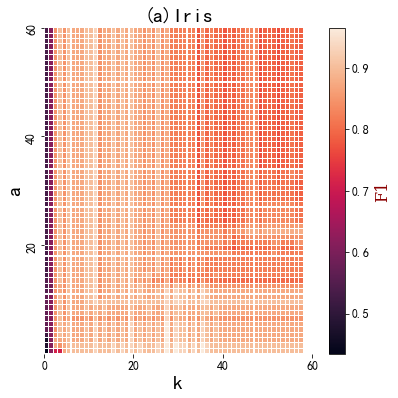

In [5]:
plot_fscore(iris_F1,'(a)Iris')

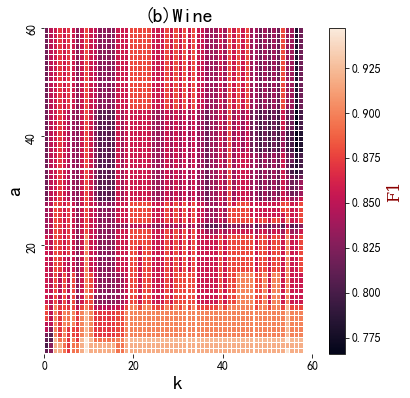

Wall time: 2h 6min 7s


In [6]:
%%time
from sklearn.datasets import load_wine
wine= load_wine()
wine_sample = pd.DataFrame(wine.data, columns=wine.feature_names)
wine_sample = pd.DataFrame(min_max_scaler.fit_transform(np.array(wine_sample)))
wine_sample['label'] = wine.target
wine_F1=run(wine_sample)
plot_fscore(wine_F1,'(b)Wine')

In [ ]:
%%time
seeds=pd.read_table('C:/Users/liu/python works/mydata/Seed.txt',engine='python')
seeds.columns=(['area','perimeter','compactness','length of kernel','width of kernel','asymmetry coefficient','length of kernel groove','label'])
seeds_sample=seeds[['area','perimeter','compactness','length of kernel','width of kernel','asymmetry coefficient','length of kernel groove']]
seeds_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(seeds_sample)))
seeds_sample['label']=seeds.label
seeds_F1=run(seeds_sample)
plot_fscore(seeds_F1,'(c)Seeds')

In [ ]:
%%time
glass=pd.read_csv('C:/Users/liu/python works/mydata/glass.csv')
glass_sample=glass.drop(['label'],axis=1)
glass_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(glass_sample)))
glass_sample['label']=glass.label
glass_F1=run(glass_sample)
plot_fscore(glass_F1,'(d)Glass')

In [ ]:
%%time
ecoli=pd.read_csv('C:/Users/liu/python works/mydata/ecoli.csv')
ecoli_F1=run(ecoli)
plot_fscore(ecoli_F1,'(e)Ecoli')

In [ ]:
%%time
statlog=pd.read_csv('C:/Users/liu/python works/mydata/statlog.csv',engine='python')
statlog.drop_duplicates(inplace=True)
statlog_sample=statlog[['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18']]
statlog_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(statlog_sample)))
statlog_sample['label']=statlog.label  
statlog_F1=run(statlog_sample)
plot_fscore(statlog_F1,'(h)Statlog')

In [ ]:
%%time
yeast=pd.read_csv('C:/Users/liu/python works/mydata/yeast.csv',engine='python')
yeast_sample=yeast.drop(['label'],axis=1)
yeast_sample=pd.DataFrame(min_max_scaler.fit_transform(np.array(yeast_sample)))
yeast_sample['label']=yeast.label
yeast_F1=run(yeast_sample)
plot_fscore(yeast_F1,'(h)yeast')